# 05 - Results

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/BDB 2025/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2025


In [2]:
# !pip install pyspark
# !pip install nfl_data_py

# The entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("DataFrame").getOrCreate()

In [ ]:
# !pip install nfl_data_py

In [3]:
!pip install nfl_data_py

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter


pd.set_option('display.max_columns', 500)

from pyspark.sql.functions import *
from pyspark.sql import functions as F

from ipywidgets import interact, fixed

import dateutil
from math import radians
from IPython.display import Video


import warnings
warnings.filterwarnings('ignore')

import time

import nfl_data_py as nfl

import urllib
from PIL import Image
from io import BytesIO

from pyspark.ml.classification import MultilayerPerceptronClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer,IndexToString,OneHotEncoder,VectorAssembler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which i

In [4]:
games = spark.read.option("header",'True').csv('./data/games.csv')
players = spark.read.option("header",'True').csv('./data/players.csv')
plays = spark.read.option("header",'True').csv('./data/plays.csv')
player_play = spark.read.option("header",'True').csv('./data/player_play.csv')
tracking = spark.read.option("header",'True').csv('./data/tracking_week_8.csv')
predictions_shotgun = spark.read.option("header",'True').parquet('./data/nnpredictions_shotgun.parquet')
predictions_underCenter = spark.read.option("header",'True').parquet('./data/nnpredictions_UnderCenter.parquet')
predictions = predictions_shotgun.union(predictions_underCenter)
# predictions = spark.read.option("header",'True').parquet('./data/nnpredictions.parquet')

shotgunFeatureImportance = pd.read_csv('./data/shotgunFeatureImportance.csv')
underCenterFeatureImportance = pd.read_csv('./data/underCenterFeatureImportance.csv')

In [ ]:
# predictions.show(5)

+----------+------+-------+-----+--------------------+----------+--------+--------------------+--------------------+----------+--------------+
|    gameId|playId|frameId|nflId|            features|routeRanId|routeRan|       rawPrediction|         probability|prediction|predictedLabel|
+----------+------+-------+-----+--------------------+----------+--------+--------------------+--------------------+----------+--------------+
|2022103008|  1002|      1|47834|(86,[0,1,2,3,4,5,...|       1.0|   HITCH|[0.78196381776437...|[0.10666520087879...|       2.0|          FLAT|
|2022103008|  1002|      1|52608|(86,[0,1,2,3,4,5,...|       6.0|    POST|[0.78061757475109...|[0.10650425669953...|       2.0|          FLAT|
|2022103008|  1002|      1|53439|(86,[0,1,2,3,4,5,...|       5.0|      IN|[0.78061757475109...|[0.10650425669953...|       2.0|          FLAT|
|2022103008|  1002|    101|47834|(86,[0,1,2,4,5,7,...|       1.0|   HITCH|[1.85286746244407...|[0.25077196521666...|       0.0|            GO|

# Predictability vs EPA/Pass

Compare the average accuracy of each play with EPA/Pass

In [ ]:
modelAccuracy = predictions.withColumn('Hit', when(col('prediction') == col('routeRanId'), 1).otherwise(0))
modelAccuracy = modelAccuracy.groupBy('gameId','playId').agg(F.avg('Hit').alias('Accuracy'))
modelAccuracy = modelAccuracy.join(plays.select('gameId','playId','expectedPointsAdded'), on=['gameId','playId'], how='inner')
# predictions.show(5)

In [ ]:
modelAccuracy = modelAccuracy.toPandas()
# this field is a string in Spark; therefore, convert it to a float
modelAccuracy['expectedPointsAdded'] = modelAccuracy['expectedPointsAdded'].astype(float).round(2)
modelAccuracy['Accuracy'] = modelAccuracy['Accuracy'].astype(float).round(2)
modelAccuracy.head()

,gameId,playId,Accuracy,expectedPointsAdded
0,2022110603,2951,0.93,1.66
1,2022110606,3581,0.40,-3.36
2,2022103011,3225,0.47,-1.36
3,2022103001,4353,0.20,0.82
4,2022103012,2900,0.36,-5.51


In [ ]:
modelAccuracy.corr()['expectedPointsAdded']

,expectedPointsAdded
Accuracy,0.003701
expectedPointsAdded,1.000000


0.0


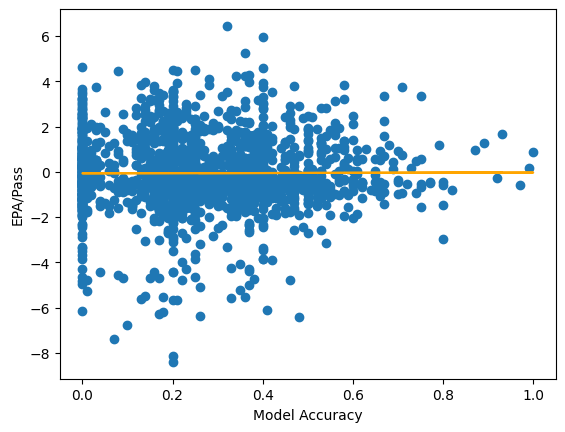

In [ ]:
# modelAccuracy = modelAccuracy[modelAccuracy['Accuracy']>0.5]
print(modelAccuracy.corr()['expectedPointsAdded'][0].round(2))
plt.scatter(modelAccuracy['Accuracy'],modelAccuracy['expectedPointsAdded'])
#obtain m (slope) and b(intercept) of linear regression line
x = modelAccuracy['Accuracy']
y = modelAccuracy['expectedPointsAdded']
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot
plt.plot(x, m*x+b, color='orange')

plt.xlabel('Model Accuracy')
plt.ylabel('EPA/Pass')

plt.show()

# What Does Predictability Look Like?

Use feature importance to get the most important features and see how those features interact with model accuracy.

# Accuracy by Team

Generate F1 scores for each team

Compare the F1 scores (x-axis) against the EPA/Pass (y-axis)

In [ ]:
teamPredict = predictions.withColumn('Hit', when(col('prediction') == col('routeRanId'), 1).otherwise(0))
teamPredict = teamPredict.join(plays.select('gameId','playId','possessionTeam'), on=['gameId','playId'], how='inner')
teamPredict = teamPredict.groupBy('possessionTeam').agg(F.avg('Hit').alias('Accuracy'))
teamEPA = plays.groupBy('possessionTeam').agg(F.avg('expectedPointsAdded').alias('expectedPointsAdded'))
teamPredict = teamPredict.join(teamEPA, on='possessionTeam', how='inner')
# teamPredict.show(5)
teamPredict = teamPredict.toPandas()
teamPredict.head()

,possessionTeam,Accuracy,expectedPointsAdded
0,NYJ,0.263348,-0.093818
1,CAR,0.288467,-0.124047
2,LA,0.284393,-0.126339
3,TB,0.223071,-0.066833
4,DET,0.258098,-0.057359


In [ ]:
team_colors = nfl.import_team_desc()
teamPredict = teamPredict.merge(team_colors, left_on='possessionTeam', right_on='team_abbr', how='left')

In [ ]:
teamPredict.head()

,possessionTeam,Accuracy,expectedPointsAdded,team_abbr,team_name,team_id,team_nick,team_conf,team_division,team_color,team_color2,team_color3,team_color4,team_logo_wikipedia,team_logo_espn,team_wordmark,team_conference_logo,team_league_logo,team_logo_squared
0,NYJ,0.234813,-0.093818,NYJ,New York Jets,3430,Jets,AFC,AFC East,#003F2D,#000000,NaN,NaN,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/nyj.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
1,CAR,0.267256,-0.124047,CAR,Carolina Panthers,750,Panthers,NFC,NFC South,#0085CA,#000000,#bfc0bf,#0085ca,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500-dark...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
2,LA,0.258748,-0.126339,LA,Los Angeles Rams,2510,Rams,NFC,NFC West,#003594,#FFD100,#001532,#af925d,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/lar.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
3,TB,0.223944,-0.066833,TB,Tampa Bay Buccaneers,4900,Buccaneers,NFC,NFC South,#A71930,#322F2B,#000000,#ff7900,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/tb.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...
4,DET,0.246184,-0.057359,DET,Detroit Lions,1540,Lions,NFC,NFC North,#0076B6,#B0B7BC,#000000,#004e89,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/det.png,https://github.com/nflverse/nflverse-pbp/raw/m...,https://github.com/nflverse/nflverse-pbp/raw/m...,https://raw.githubusercontent.com/nflverse/nfl...,https://github.com/nflverse/nflverse-pbp/raw/m...


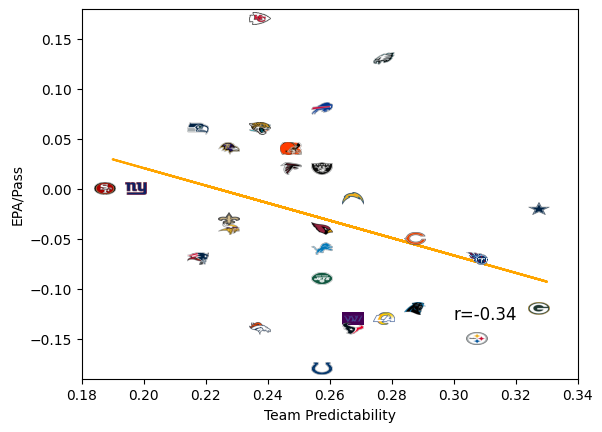

In [ ]:
teamPredict['Accuracy'] = teamPredict['Accuracy'].astype(float).round(2)
teamPredict['expectedPointsAdded'] = teamPredict['expectedPointsAdded'].astype(float).round(2)
correlation = teamPredict[['Accuracy','expectedPointsAdded']].corr()['expectedPointsAdded'][0].round(2)

# modelAccuracy = modelAccuracy[modelAccuracy['Accuracy']>0.5]
# print(correlation)
# plt.scatter(teamPredict['Accuracy'],teamPredict['expectedPointsAdded'])
# fig = plt.figure(figsize=(12,8),facecolor='#ffff')
plt.plot()

#obtain m (slope) and b(intercept) of linear regression line
x = teamPredict['Accuracy']
y = teamPredict['expectedPointsAdded']
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot
plt.plot(x, m*x+b, color='orange')

# logos
for i in teamPredict['possessionTeam']:
    url = teamPredict[teamPredict['possessionTeam']==i]['team_logo_wikipedia'].iloc[0]
    with urllib.request.urlopen(url) as url_response:
      image_data = url_response.read()
    # a = plt.imread(teamPredict[teamPredict['possessionTeam']==i]['team_logo_wikipedia'].iloc[0])
    a = np.array(Image.open(BytesIO(image_data)))
    teamPredictability = teamPredict[teamPredict['possessionTeam']==i]['Accuracy'].iloc[0]
    teamEPA = teamPredict[teamPredict['possessionTeam']==i]['expectedPointsAdded'].iloc[0]
    plt.imshow(a, extent=[teamPredictability-0.006, teamPredictability+0.001, teamEPA-0.006, teamEPA+0.007], aspect='auto', zorder=2)

plt.xlabel('Team Predictability')
plt.ylabel('EPA/Pass')

plt.text(0.3, -0.13, f"r={correlation}", fontsize = 12)

plt.xlim(teamPredict['Accuracy'].min()-0.01,teamPredict['Accuracy'].max()+0.01)
plt.ylim(teamPredict['expectedPointsAdded'].min()-0.01,teamPredict['expectedPointsAdded'].max()+0.01)

# plt.show()

plt.savefig(
    './visuals/teamPredictabilityVsEPAPass.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

The data gives evidence that teams that are more predictable have a lower EPA/Pass.

# Accuracy by Player

Generate F1 scores for each player

Compare F1 scores (x-axis) against EPA/Target (y-axis)

In [ ]:
passCatchers = player_play.filter(player_play.hadPassReception=='1')
passCatchers = passCatchers.select('gameId','playId','nflId').join(plays.select('gameId','playId','expectedPointsAdded'),on=['gameId','playId'], how='left')
passCatchers.show(5)

+----------+------+-----+-------------------+
|    gameId|playId|nflId|expectedPointsAdded|
+----------+------+-----+-------------------+
|2022090800|    56|42489| 0.0044204024598002|
|2022090800|   122|47857|  0.399208846967667|
|2022090800|   167|42489|   1.37344093748834|
|2022090800|   212|52494|  0.547352206544019|
|2022090800|   236|52536|   2.91832571139093|
+----------+------+-----+-------------------+
only showing top 5 rows



In [ ]:
passCatchers = player_play.filter(player_play.hadPassReception=='1')
passCatchers = passCatchers.select('gameId','playId','nflId').join(plays.select('gameId','playId','expectedPointsAdded'),on=['gameId','playId'], how='left')
playerPredict = predictions.withColumn('Hit', when(col('prediction') == col('routeRanId'), 1).otherwise(0))
playerPredict = playerPredict.groupBy('nflId').agg(F.avg('Hit').alias('Accuracy'))
totalRoutes = passCatchers.groupBy('nflId').count().withColumnRenamed("count", "totalPlays")
playerPredict = playerPredict.join(totalRoutes, on='nflId', how='inner')
playerEPA = passCatchers.groupBy('nflId').agg(F.avg('expectedPointsAdded').alias('expectedPointsAdded'))
playerPredict = playerPredict.join(playerEPA, on='nflId', how='inner')
# playerPredict.select('totalPlays').agg({'totalPlays':'min'}).show()
# minimum is 1 catch
# playerPredict.select('totalPlays').agg({'totalPlays':'max'}).show()
# max is 73 catches
# playerPredict.count()
# 330 total pass catchers
playerPredict = playerPredict.filter(playerPredict.totalPlays>=12)
# get receivers down to 160 pass catchers (32 teams, 5 pass catchers on each play)
# playerPredict.show(5)
playerPredict = playerPredict.toPandas()
playerPredict.head()

,nflId,Accuracy,totalPlays,expectedPointsAdded
0,47839,0.292251,25,1.085292
1,44860,0.483871,36,0.271674
2,54905,0.646982,12,-0.124281
3,54572,0.452235,18,-0.032870
4,54518,0.166698,25,1.379846


-0.55


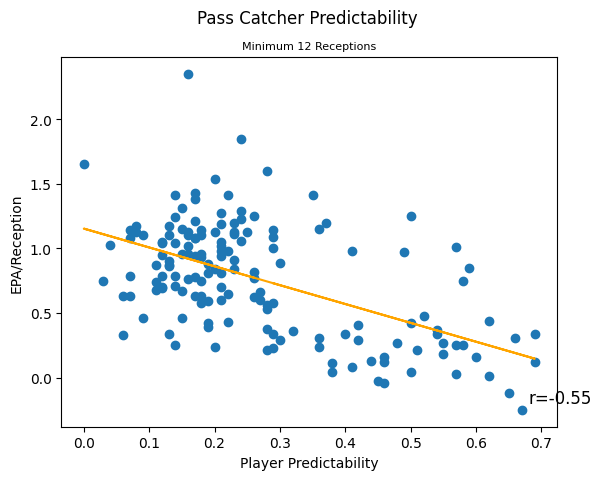

In [ ]:
playerPredict['Accuracy'] = playerPredict['Accuracy'].astype(float).round(2)
playerPredict['expectedPointsAdded'] = playerPredict['expectedPointsAdded'].astype(float).round(2)
correlation = playerPredict[['Accuracy','expectedPointsAdded']].corr()['expectedPointsAdded'][0].round(2)
# modelAccuracy = modelAccuracy[modelAccuracy['Accuracy']>0.5]
print(correlation)
plt.scatter(playerPredict['Accuracy'],playerPredict['expectedPointsAdded'])
#obtain m (slope) and b(intercept) of linear regression line
x = playerPredict['Accuracy']
y = playerPredict['expectedPointsAdded']
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot
plt.plot(x, m*x+b, color='orange')

plt.xlabel('Player Predictability')
plt.ylabel('EPA/Reception')

plt.text(0.68, -0.2, f"r={correlation}", fontsize = 12)
plt.suptitle('Pass Catcher Predictability',x=0.51)#,y=0.9, x=0.52,fontsize=34)
plt.title('Minimum 12 Receptions',fontsize=8)#,y=0.9,x=0.5,fontsize=15)

# plt.show()

plt.savefig(
    './visuals/playerPredictabilityVsEPAPass.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

The data gives evidence that players can be predictable and when a player is predictable, they are less efficient.

# Motion vs Predicatability

How does motion at the snap affect the accuracy of the model? Use a histogram to plot the accuracy of the model and group by motion at the snap.

In [ ]:
from pyspark.sql.types import DoubleType,IntegerType

motionAtSnap = player_play.withColumn('inMotionAtBallSnap', when(col("inMotionAtBallSnap")=='TRUE',1).otherwise(0))
motionAtSnap = motionAtSnap.groupBy('gameId','playId').agg(F.avg('inMotionAtBallSnap').alias('inMotionAtBallSnap'))
motionAtSnap = motionAtSnap.withColumn('inMotionAtBallSnap', when(col("inMotionAtBallSnap")>0,1).otherwise(0))
motionAtSnap.show(5)

motionPredict = predictions.withColumn('Hit', when(col('prediction') == col('routeRanId'), 1).otherwise(0))
motionPredict = motionPredict.groupBy('gameId','playId').agg(F.avg('Hit').alias('Accuracy'))
motionPredict.show(5)

motionAtSnap = motionAtSnap.join(motionPredict, on=['gameId','playId'], how='inner')

motionAtSnap = motionAtSnap.toPandas()

+----------+------+------------------+
|    gameId|playId|inMotionAtBallSnap|
+----------+------+------------------+
|2022091100|   522|                 0|
|2022091101|  3862|                 1|
|2022091107|  1642|                 0|
|2022091108|  1196|                 1|
|2022091110|   799|                 0|
+----------+------+------------------+
only showing top 5 rows



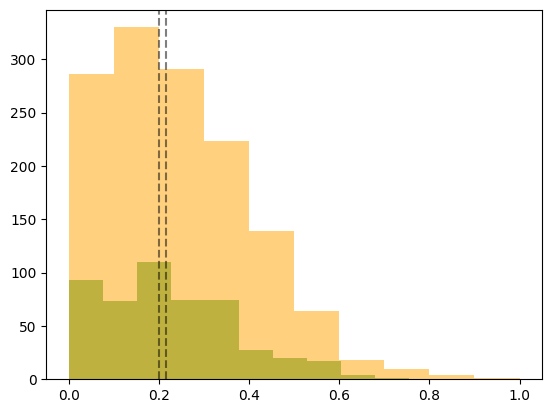

In [ ]:
median_motion = motionAtSnap[(motionAtSnap['inMotionAtBallSnap']==1)]['Accuracy'].median()
median_no_motion = motionAtSnap[(motionAtSnap['inMotionAtBallSnap']==0)]['Accuracy'].median()

plt.hist(motionAtSnap[motionAtSnap['inMotionAtBallSnap']==1]['Accuracy'],color='green',alpha=0.5)
plt.hist(motionAtSnap[motionAtSnap['inMotionAtBallSnap']==0]['Accuracy'],color='orange',alpha=0.5)

plt.axvline(x=median_motion,color='black',ls='--',alpha=0.5)
plt.axvline(x=median_no_motion,color='black',ls='--',alpha=0.5)

Not really any benefit in using motion to confuse the defense. Plays with motion are just as predictable as plays without it. This is probably because teams will use motion to set up specific routes.

# Targets/Route vs Predictability

How does route predictability affect targets/route? Are predictable receivers targeted more/less?

In [ ]:
# calculate total routes ran and total targets
targetRoutes = player_play.groupBy('nflId').agg(F.sum('wasTargettedReceiver').alias('Targets'),F.sum('wasRunningRoute').alias('Routes'))
targetRoutes = targetRoutes.filter(targetRoutes['Routes']>0)
targetRoutes = targetRoutes.withColumn('targetsPerRoute', col('Targets')/col('Routes'))
# targetRoutes.show(5)

# calculate average predictability for each receiver
playerPredict = predictions.withColumn('Hit', when(col('prediction') == col('routeRanId'), 1).otherwise(0))
playerPredict = playerPredict.groupBy('nflId').agg(F.avg('Hit').alias('Accuracy'))
# playerPredict.show(5)

# join the two tables
targetRoutes = targetRoutes.join(playerPredict, on='nflId', how='inner')
# targetRoutes.show(5)

targetRoutes = targetRoutes.toPandas()
targetRoutes.head()

,nflId,Targets,Routes,targetsPerRoute,Accuracy
0,54905,13.0,75.0,0.173333,0.514436
1,55014,4.0,15.0,0.266667,0.444365
2,44860,48.0,186.0,0.258065,0.416322
3,54572,22.0,88.0,0.250000,0.345121
4,53658,8.0,70.0,0.114286,0.174910


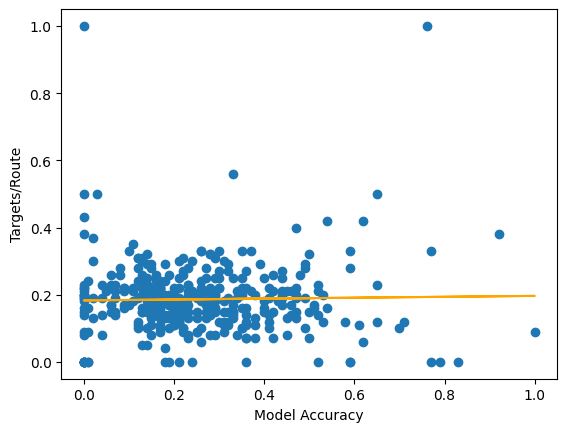

In [ ]:
targetRoutes['Accuracy'] = targetRoutes['Accuracy'].astype(float).round(2)
targetRoutes['targetsPerRoute'] = targetRoutes['targetsPerRoute'].astype(float).round(2)

# modelAccuracy = modelAccuracy[modelAccuracy['Accuracy']>0.5]
# print(playerPredict[['Accuracy','targetsPerRoute']].corr()['targetsPerRoute'][0].round(2))
plt.scatter(targetRoutes['Accuracy'],targetRoutes['targetsPerRoute'])
#obtain m (slope) and b(intercept) of linear regression line
x = targetRoutes['Accuracy']
y = targetRoutes['targetsPerRoute']
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot
plt.plot(x, m*x+b, color='orange')

plt.xlabel('Model Accuracy')
plt.ylabel('Targets/Route')

plt.show()

Player route predictability doesn't limit the number of targets per route ran. This result coupled with the Predictability vs EPA/Reception graph shows that it's not the bad receivers that are causing the negative relationship between predictability and EPA/Reception. Rather, it's the DBs ability to read the route that causes the change in efficiency. In other words, bad receivers aren't limited to a small route tree because of performance. If a WRs route combination was dependent on his efficiency, we would see a similar negative relationship here because bad receivers would be more predictable and have fewer targets per route. However, there is no relationship in predicatability and whether the WR will be targeted

# Play Animation

Choose a play and show how the prediction changes throughout the play

Would be cool to do one play with motion and one without.

Start with original tracking data so we can have the post snap frames. Join in the predictions to add a label to each receiver giving the predicted route.

[code](https://www.kaggle.com/code/ar2017/nfl-big-data-bowl-2021-animating-players-movement)

In [34]:
# most accurate play
playerPredict = predictions.withColumn('Hit', when(col('prediction') == col('routeRanId'), 1).otherwise(0))
playerPredict = playerPredict.groupBy('gameId','playId').agg(F.avg('Hit').alias('Accuracy')).join(plays.select('gameId','playId','secRemainHalf'), on=['gameId','playId']).join(games.select('gameId','week'), on='gameId', how='inner')
playerPredict.filter(playerPredict['secRemainHalf']>120).filter(playerPredict['week']==8).orderBy(['Accuracy'], ascending = [False]).show(5)

+----------+------+------------------+-------------+----+
|    gameId|playId|          Accuracy|secRemainHalf|week|
+----------+------+------------------+-------------+----+
|2022103002|   544|0.9882352941176471|         1367|   8|
|2022103002|   370|              0.97|         1518|   8|
|2022103010|   751|0.9202453987730062|          957|   8|
|2022103008|  1809|               0.8|          295|   8|
|2022103012|  3587|0.7521739130434782|          154|   8|
+----------+------+------------------+-------------+----+
only showing top 5 rows



In [35]:
game = 2022103002
play = 370
predictions.filter(predictions['gameId']==game).filter(predictions['playId']==play).show(5)

+----------+------+-------+-----+--------------------+----------+--------+--------------------+--------------------+----------+--------------+
|    gameId|playId|frameId|nflId|            features|routeRanId|routeRan|       rawPrediction|         probability|prediction|predictedLabel|
+----------+------+-------+-----+--------------------+----------+--------+--------------------+--------------------+----------+--------------+
|2022103002|   370|      1|48207|(77,[0,1,2,3,4,5,...|       2.0|    FLAT|[0.75727705416266...|[0.11264084521655...|       2.0|          FLAT|
|2022103002|   370|      1|52451|(77,[0,1,2,3,4,5,...|       2.0|    FLAT|[0.75727705450697...|[0.11264084526957...|       2.0|          FLAT|
|2022103002|   370|      1|52581|(77,[0,1,2,3,4,5,...|       0.0|      GO|[1.08017071695657...|[0.16196064258568...|       0.0|            GO|
|2022103002|   370|     10|48207|(77,[0,1,2,3,4,5,...|       2.0|    FLAT|[0.86138387643602...|[0.12751804827257...|       2.0|          FLAT|

In [ ]:
games.filter(games['gameId']==game).show()

+----------+------+----+----------+---------------+------------+---------------+--------------+-----------------+
|    gameId|season|week|  gameDate|gameTimeEastern|homeTeamAbbr|visitorTeamAbbr|homeFinalScore|visitorFinalScore|
+----------+------+----+----------+---------------+------------+---------------+--------------+-----------------+
|2022103002|  2022|   8|10/30/2022|       13:00:00|         DAL|            CHI|            49|               29|
+----------+------+----+----------+---------------+------------+---------------+--------------+-----------------+



In [ ]:
plays.filter(plays['gameId']==game).filter(plays['playId']==play).show(5)

+----------+------+--------------------+-------+----+---------+--------------+-------------+------------+--------------+---------+----------------+-------------------+----------------------+----------------------+-----------------------------+--------------------------------+----------------+----------------+-----------------+---------------+----------+----------+-------+-------+----------+------------+----------------+----------------+-----------+----------------+----------+----------------+-----------------+-------+-------+-------+----------------+------------+---------------------+-----------+---------------------------+----------------------------+-------------------+----------+---------------------+-----------------------+-----------------+----------------+-----------+-------------+
|    gameId|playId|     playDescription|quarter|down|yardsToGo|possessionTeam|defensiveTeam|yardlineSide|yardlineNumber|gameClock|preSnapHomeScore|preSnapVisitorScore|playNullifiedByPenalty|absoluteYar

In [ ]:
plays.filter(plays['gameId']==game).filter(plays['playId']==play).select('playDescription').show(20, False)

+---------------------------------------------------------------------+
|playDescription                                                      |
+---------------------------------------------------------------------+
|(10:18) (Shotgun) J.Fields pass incomplete deep right to E.St. Brown.|
+---------------------------------------------------------------------+



In [ ]:
# motion_play = player_play[(player_play['teamAbbr']=='TEN') & (player_play['inMotionAtBallSnap']==1)]
# pass_motion = plays[plays['isDropback']==1].merge(motion_play, on=['gameId','playId'], how='inner')
# pass_motion = pass_motion.merge(games, on='gameId', how='inner')
# pass_motion = pass_motion[pass_motion['week']==8]
# pass_motion
# # pass_motion.sort_values(by=['passLength'],ascending=False).head()
# pass_motion_game = pass_motion[(pass_motion['gameId']==2022103004) & (pass_motion['playId']==2553)]
# # gameId=='2022091108'
# # playId=='729'
# # pass_motion_game.merge(games, on='gameId', how='inner')[['gameId','playId','playDescription','quarter','down','yardsToGo','week']]
# pass_motion_game[['gameId','playId','playDescription','quarter','down','yardsToGo','week']]

In [36]:
# plays.filter(plays['gameId']==2022103002).filter(plays['playId']==544).select('playDescription').show(20, False)
animation_play = tracking.filter(tracking['gameId']==game).filter(tracking['playId']==play).toPandas()
samplePredictions = predictions.filter(predictions['gameId']==game).filter(predictions['playId']==play).toPandas()
animation_play = animation_play.merge(samplePredictions, on=['gameId','playId','nflId','frameId'], how='left')

In [ ]:
animation_play.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,features,routeRanId,routeRan,rawPrediction,probability,prediction,predictedLabel
0,2022103002,370,38553,Riley Reiff,1,BEFORE_SNAP,2022-10-30 17:13:12.6,71,CHI,left,86.47,26.86,1.09,1.29,0.11,253.51,277.3,huddle_break_offense,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022103002,370,38553,Riley Reiff,2,BEFORE_SNAP,2022-10-30 17:13:12.7,71,CHI,left,86.38,26.86,0.89,1.38,0.09,251.99,273.46,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022103002,370,38553,Riley Reiff,3,BEFORE_SNAP,2022-10-30 17:13:12.8,71,CHI,left,86.31,26.87,0.72,1.35,0.07,251.99,270.85,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022103002,370,38553,Riley Reiff,4,BEFORE_SNAP,2022-10-30 17:13:12.9,71,CHI,left,86.25,26.87,0.54,1.39,0.06,251.99,270.09,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022103002,370,38553,Riley Reiff,5,BEFORE_SNAP,2022-10-30 17:13:13,71,CHI,left,86.21,26.87,0.38,1.33,0.04,253.47,265.8,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(-5.0, 58.3)

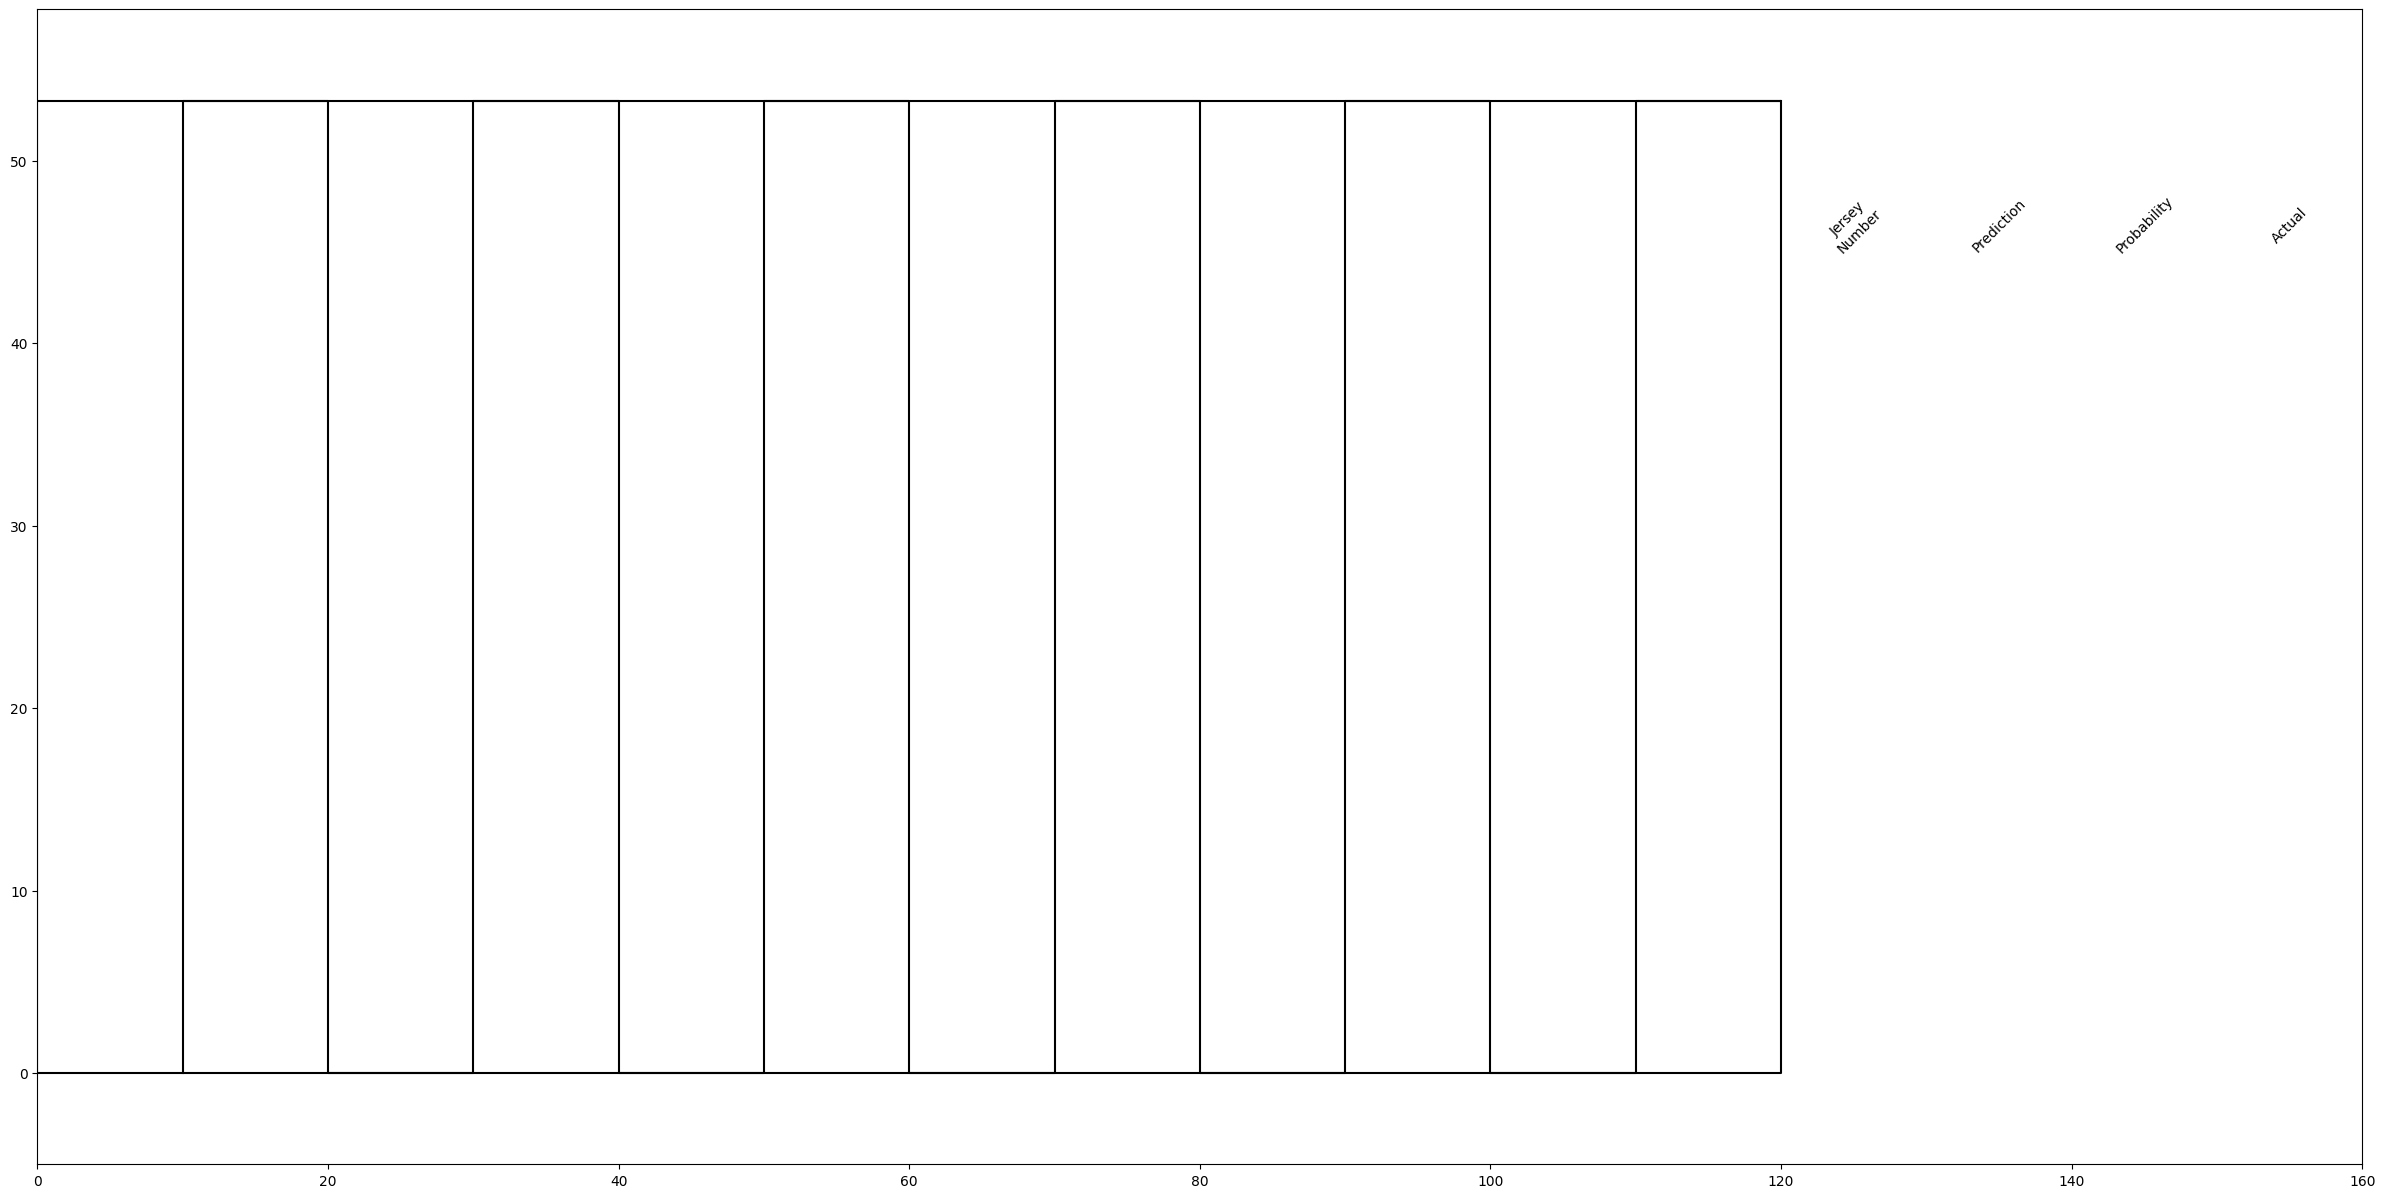

In [87]:
# fig, ax = plt.subplots(1, figsize=(12, 6.33))
fig, ax = plt.subplots(1, figsize=(30, 15))
plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='black')
plt.text(125, 46.5, 'Jersey\nNumber', va='center', ha='center', color='black', size='medium', rotation=45)
plt.text(135, 46.5, 'Prediction', va='center', ha='center', color='black', size='medium', rotation=45)
plt.text(155, 46.5, 'Actual', va='center', ha='center', color='black', size='medium', rotation=45)
plt.text(145, 46.5, 'Probability', va='center', ha='center', color='black', size='medium', rotation=45)

plt.xlim(0, 160)
plt.ylim(-5, 58.3)

In [93]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          # figsize=(30, 15)):
                          # figsize=(20, 8)):
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                # facecolor='blue',
                                facecolor='white',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                # facecolor='blue',
                                facecolor='white',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    # plt.xlim(0, 120)
    plt.xlim(0, 160)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='blue')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')

    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')

    # table
    plt.text(125, 46.5, 'Jersey\nNumber', va='center', ha='center', color='black', size='medium', rotation=45)
    plt.text(135, 46.5, 'Prediction', va='center', ha='center', color='black', size='medium', rotation=45)
    plt.text(155, 46.5, 'Actual', va='center', ha='center', color='black', size='medium', rotation=45)
    plt.text(145, 46.5, 'Probability', va='center', ha='center', color='black', size='medium', rotation=45)

    return fig, ax

In [98]:
def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    angle = float(angle)
    speed = float(speed)
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.cos(radians(angle)) * multiplier * speed
        dy = -np.sin(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy


def animate_player_movement(weekNumber, playId, gameId):
    # weekData = pd.read_csv('../input/nfl-big-data-bowl-2021/week' + str(weekNumber) + '.csv')
    weekData = animation_play.copy()
    weekData['o'] = weekData[weekData['club']!='football']['o'].astype(float)
    weekData['x'] = weekData[weekData['club']!='football']['x'].astype(float)
    weekData['y'] = weekData[weekData['club']!='football']['y'].astype(float)
    playData = pd.read_csv('./data/plays.csv')
    # playData = plays.toPandas()

    playHome = weekData.query('(gameId=="' + str(gameId) + '") & (playId=="' + str(playId) + '") & (club == "DAL")')
    playAway = weekData.query('(gameId=="' + str(gameId) + '") & (playId=="' + str(playId) + '") & (club == "CHI")')
    playFootball = weekData.query('(gameId=="' + str(gameId) + '") & (playId=="' + str(playId) + '") & (club == "football")')

    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')

    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())

    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()

    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber

    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo

    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')

    def update_animation(time):
        patch = []

        # Home players' location
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        homePrediction = playHome.query('time == ' + str(time))['predictedLabel']
        homeRouteRanId = playHome.query('time == ' + str(time))['routeRan']
        homeProbability = playHome.query('time == ' + str(time))['probability']
        patch.extend(plt.plot(homeX, homeY, 'o',c='blue', ms=15, mec='white'))

        # Home players' jersey number
        # plt.text(125, 46.5, 'Jersey\nNumber', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, num, pred in zip(homeX, homeY, homeNum, homePrediction):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='xx-small'))
            if pd.notna(pred):
              patch.append(plt.text(125, tablePlot, num, va='center', ha='center', color='black', size='medium'))
              tablePlot += 5

        # Home player's prediction
        # plt.text(135, 46.5, 'Prediction', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, pred in zip(homeX, homeY, homePrediction):
          if pd.notna(pred):
              patch.append(plt.text(135, tablePlot, pred, va='center', ha='center', color='white', size='medium'))
              # add probability below the test
              # patch.append(plt.text(0, -3, pred, va='center', ha='center', color='black', size='medium'))
              # patch.append(plt.text(x+5, y-3, route, va='center', ha='center', color='black', size='medium'))
              tablePlot += 5

        # Home player's actual route
        # plt.text(155, 46.5, 'Actual', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, route, pred in zip(homeX, homeY, homeRouteRanId, homePrediction):
          if pd.notna(pred):
            patch.append(plt.text(155, tablePlot, route, va='center', ha='center', color='black', size='medium'))
            tablePlot += 5

        # Home route probability
        # plt.text(145, 46.5, 'Probability', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, prob, pred in zip(homeX, homeY, homeProbability, homePrediction):
          if pd.notna(pred):
            patch.append(plt.text(145, tablePlot, np.round(float(prob.max()),2), va='center', ha='center', color='black', size='medium'))
            tablePlot += 5

        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(float(x), float(y), float(dx), float(dy), color='blue', width=0.15, shape='full'))

        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(float(x), float(y), float(dx), float(dy), color='black', width=0.25, shape='full'))

        # Away players' location
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        awayPrediction = playAway.query('time == ' + str(time))['predictedLabel']
        awayRouteRanId = playAway.query('time == ' + str(time))['routeRan']
        awayProbability = playAway.query('time == ' + str(time))['probability']
        patch.extend(plt.plot(awayX, awayY, 'o',c='white', ms=15, mec='black'))

        # Away players' jersey number
        # plt.text(125, 46.5, 'Jersey\nNumber', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, num, pred in zip(awayX, awayY, awayNum,awayPrediction):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='xx-small'))
            if pd.notna(pred):
              patch.append(plt.text(125, tablePlot, num, va='center', ha='center', color='black', size='medium'))
              tablePlot += 5

        # Away player's prediction
        # plt.text(135, 46.5, 'Prediction', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, pred in zip(awayX, awayY, awayPrediction):
          if pd.notna(pred):
              patch.append(plt.text(135, tablePlot, pred, va='center', ha='center', color='black', size='medium'))
              # add probability below the test
              # patch.append(plt.text(0, -3, pred, va='center', ha='center', color='black', size='medium'))
              # patch.append(plt.text(x+5, y-3, route, va='center', ha='center', color='black', size='medium'))
              tablePlot += 5

        # Away player's actual route
        # plt.text(155, 46.5, 'Actual', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, route, pred in zip(awayX, awayY, awayRouteRanId, awayPrediction):
          if pd.notna(pred):
            patch.append(plt.text(155, tablePlot, route, va='center', ha='center', color='black', size='medium'))
            tablePlot += 5

        # Away route probability
        # plt.text(145, 46.5, 'Probability', va='center', ha='center', color='black', size='medium', rotation=45)
        tablePlot = 20
        for x, y, prob, pred in zip(awayX, awayY, awayProbability, awayPrediction):
          if pd.notna(pred):
            patch.append(plt.text(145, tablePlot, np.round(float(prob.max()),2), va='center', ha='center', color='black', size='medium'))
            tablePlot += 5

        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            # patch.append(plt.arrow(float(x), float(y), float(dx), float(dy), color='white', width=0.5, shape='full'))
            patch.append(plt.arrow(float(x), float(y), float(dx), float(dy), color='white', width=0.15, shape='full'))

        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(float(x), float(y), float(dx), float(dy), color='black', width=0.25, shape='full'))

        # Football location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='brown', data=playFootball.query('time == ' + str(time))['club']))

        return patch

    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)

    anim = animation.ArtistAnimation(fig, ims, repeat=True)

    return anim

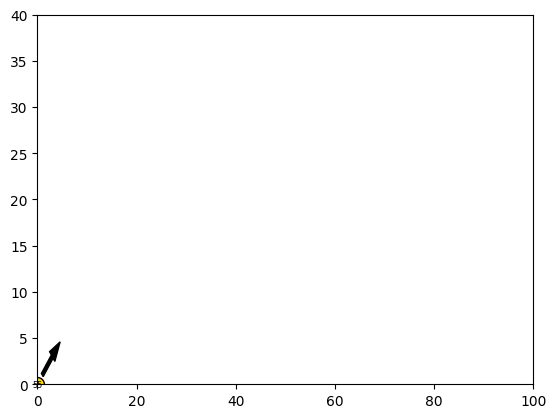

In [70]:
plt.xlim(0,100)
plt.ylim(0,40)
plt.plot(0, 0, 'o',c='gold', ms=10, mec='black')
plt.text(0, 0, 55, va='center', ha='center', color='black', size='xx-small')
# plt.plot(0.5, 0.5, 'o',c='gold', ms=20, mec='black')
plt.arrow(1, 1, 2, 2, color='black', width=0.5, shape='full')

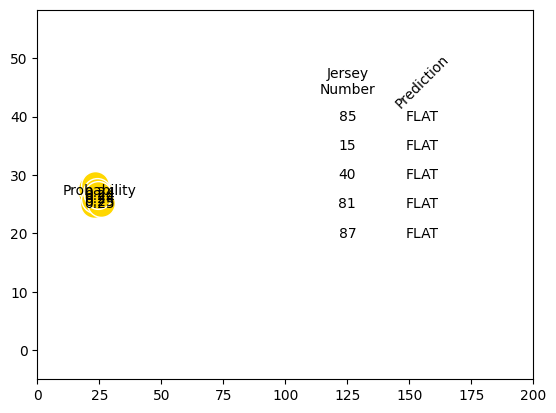

In [ ]:
# Home players' location
plt.xlim(0, 200)
plt.ylim(-5, 58.3)
weekData = animation_play.copy()
weekData['o'] = weekData[weekData['club']!='football']['o'].astype(float)
weekData['x'] = weekData[weekData['club']!='football']['x'].astype(float)
weekData['y'] = weekData[weekData['club']!='football']['y'].astype(float)

playHome = weekData.query('(gameId=="' + str(2022103004) + '") & (playId=="' + str(2553) + '") & (club == "TEN")')
homeX = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['x']
homeY = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['y']
homeNum = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['jerseyNumber']
homeOrient = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['o']
homeDir = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['dir']
homeSpeed = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['s']
homePrediction = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['predictedLabel']
homeRouteRanId = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['routeRan']
homeProbability = playHome.query('time == "' + '2022-10-30 22:18:19.5"')['probability']
plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='black')

# Home players' jersey number
plt.text(125, 46, 'Jersey\nNumber', va='center', ha='center', color='black', size='medium')
tablePlot = 20
for x, y, num, pred in zip(homeX, homeY, homeNum, homePrediction):
  if pd.notna(pred):
    # print(num)
    # for i in range(len(num)):
    #   print(num[i])
    plt.text(125, tablePlot, int(num), va='center', ha='center', color='black', size='medium')
    tablePlot += 5

# prediction label
plt.text(155, 46, 'Prediction', va='center', ha='center', color='black', size='medium', rotation=45)
tablePlot = 20
for x, y, num, pred in zip(homeX, homeY, homeNum, homePrediction):
  if pd.notna(pred):
    # print(num)
    # for i in range(len(num)):
    #   print(num[i])
    plt.text(155, tablePlot, pred, va='center', ha='center', color='black', size='medium')
    tablePlot += 5

# probability
plt.text(25.25, 27.25, 'Probability', va='center', ha='center', color='black', size='medium')
tablePlot = 25
for x, y, prob, pred in zip(homeX, homeY, homeProbability, homePrediction):
  if pd.notna(pred):
    # print(num)
    # for i in range(len(num)):
    #   print(num[i])
    test = float(prob.max())
    # print(test)
    plt.text(25, tablePlot, np.round(float(prob.max()),2), va='center', ha='center', color='black', size='medium')
    tablePlot += 0.5

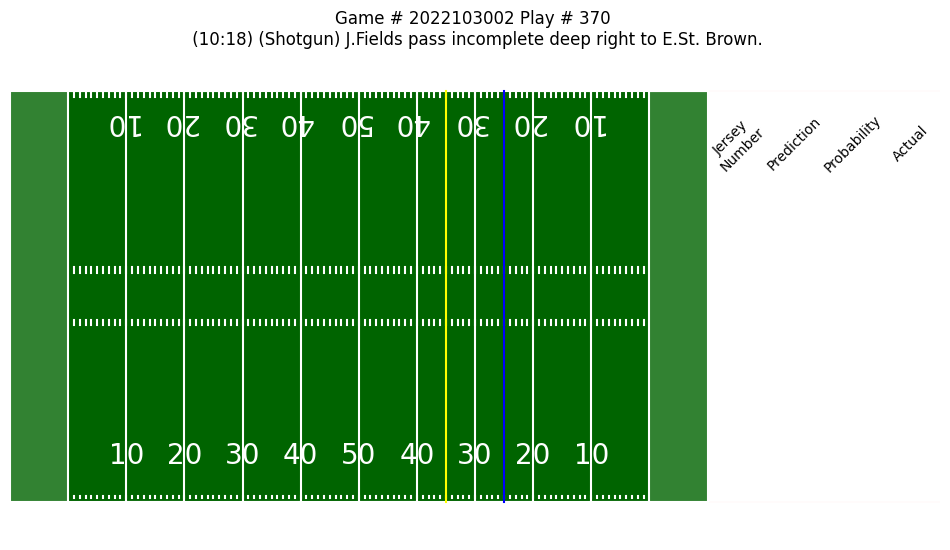

In [99]:
anim = animate_player_movement(8, play, game)

In [100]:
writer = FFMpegWriter(fps=10)
anim.save('./visuals/animation_notrail.mp4', writer=writer)

In [101]:
Video("./visuals/animation_notrail.mp4",embed=True)

# Feature Importance

Shuffle the data in each column to see how messing with the data affects the results. If the F1 score doesn't change that much, then it's not an important feature.

In [ ]:
# from pyspark.sql import functions as sf

# # load the test set
# test_df = spark.read.option("header",'True').parquet('./data/test_df_UnderCenter.parquet')

# # shuffle said column
# test_df = test_df.withColumn("shuffled_index", rand())
# shuffled_column_df = test_df.select("shuffled_index", 'X_std').orderBy("shuffled_index")
# shuffled_column_df = shuffled_column_df.withColumn("id",sf.monotonically_increasing_id())
# test_df = test_df.withColumn("id",sf.monotonically_increasing_id())
# # test_df = test_df.drop('X_std').join(shuffled_column_df, on="id").drop("shuffled_index")
# test_df = test_df.join(shuffled_column_df, on="id").drop("shuffled_index")
# # test_df = test_df.withColumn('test',shuffled_column_df.select('X_std'))
# test_df.show(5)

+---+----------+------+-----+-------+---------------+-----------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+-----+--------------+----------+-----------+------+------------------+------------------+------------------+------------------+----+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+---------------------+-------------------+---------------+---------------+-----------------+------------------+---------------------+-------------------+---------------+---------------+-----------------+------------------+----

## Under Center Feature Importance

In [ ]:
from pyspark.ml.feature import StringIndexer,IndexToString,OneHotEncoder,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as sf

# load the model
nnModel = MultilayerPerceptronClassificationModel.load('./modelUnderCenter')

test_df = spark.read.option("header",'True').parquet('./data/test_df_underCenter.parquet')

# loop through each column of the test set
features = test_df.select(
                          # player specific metrics
                          'X_std','Y_std','dir_std','s',
                          # 'o_std','a','dis',
                          # '10_def_first(dist)','10_def_first(dir_std2)','10_def_first(s2)',
                          # #  '10_def_first(a2)','10_def_first(dis2)','10_def_first(o_std2)',
                          '10_off_first(dist)','10_off_first(dir_std2)','10_off_first(s2)',
                          # # '10_off_first(a2)','10_off_first(dis2)','10_off_first(o_std2)',
                          # '11_def_first(dist)','11_def_first(dir_std2)','11_def_first(s2)',
                          # '11_def_first(a2)','11_def_first(dis2)','11_def_first(o_std2)',
                          # '1_def_first(dist)','1_def_first(dir_std2)','1_def_first(s2)',
                          # '1_def_first(a2)','1_def_first(dis2)','1_def_first(o_std2)',
                          '1_off_first(dist)','1_off_first(dir_std2)','1_off_first(s2)',
                          # '1_off_first(a2)','1_off_first(dis2)','1_off_first(o_std2)',
                          # '2_def_first(dist)','2_def_first(dir_std2)','2_def_first(s2)',
                          # '2_def_first(a2)','2_def_first(dis2)','2_def_first(o_std2)',
                          '2_off_first(dist)','2_off_first(dir_std2)','2_off_first(s2)',
                          #  '2_off_first(a2)','2_off_first(dis2)','2_off_first(o_std2)',
                          # '3_def_first(dist)','3_def_first(dir_std2)','3_def_first(s2)',
                          # '3_def_first(a2)', '3_def_first(dis2)','3_def_first(o_std2)',
                          '3_off_first(dist)','3_off_first(dir_std2)','3_off_first(s2)',
                          # '3_off_first(a2)','3_off_first(dis2)','3_off_first(o_std2)',
                          #  '4_def_first(dist)','4_def_first(dir_std2)','4_def_first(s2)',
                          # '4_def_first(a2)','4_def_first(dis2)','4_def_first(o_std2)',
                          '4_off_first(dist)','4_off_first(dir_std2)','4_off_first(s2)',
                          # '4_off_first(a2)','4_off_first(dis2)','4_off_first(o_std2)',
                          # '5_def_first(dist)','5_def_first(dir_std2)','5_def_first(s2)',
                          # '5_def_first(a2)','5_def_first(dis2)','5_def_first(o_std2)',
                          '5_off_first(dist)','5_off_first(dir_std2)','5_off_first(s2)',
                          # '5_off_first(a2)','5_off_first(dis2)','5_off_first(o_std2)',
                          # '6_def_first(dist)','6_def_first(dir_std2)','6_def_first(s2)',
                          # # '6_def_first(a2)','6_def_first(dis2)','6_def_first(o_std2)',
                          '6_off_first(dist)','6_off_first(dir_std2)','6_off_first(s2)',
                          # # '6_off_first(a2)','6_off_first(dis2)','6_off_first(o_std2)',
                          # '7_def_first(dist)','7_def_first(dir_std2)','7_def_first(s2)',
                          # # '7_def_first(a2)','7_def_first(dis2)','7_def_first(o_std2)',
                          '7_off_first(dist)','7_off_first(dir_std2)','7_off_first(s2)',
                          # # '7_off_first(a2)','7_off_first(dis2)','7_off_first(o_std2)',
                          # '8_def_first(dist)','8_def_first(dir_std2)','8_def_first(s2)',
                          # # '8_def_first(a2)','8_def_first(dis2)','8_def_first(o_std2)',
                          '8_off_first(dist)','8_off_first(dir_std2)','8_off_first(s2)',
                          # #  '8_off_first(a2)','8_off_first(dis2)','8_off_first(o_std2)',
                          # '9_def_first(dist)','9_def_first(dir_std2)','9_def_first(s2)',
                          # # '9_def_first(a2)','9_def_first(dis2)','9_def_first(o_std2)',
                          '9_off_first(dist)','9_off_first(dir_std2)','9_off_first(s2)',
                          # '9_off_first(a2)','9_off_first(dis2)','9_off_first(o_std2)',
                           # game context
                          'quarter','down','yardsToGo','preSnapPossessionTeamWinProbability',#'preSnapHomeScore','preSnapVisitorScore'
                          'secRemainHalf','relativeDistLOS',
                          # one-hot vectors
                          'offenseVec','formationVec','receiverAlignmentVec'
                           ).columns

# make predictions original test set
nnpredictionLabels = nnModel.transform(test_df)
# calculate F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='routeRanId')
originalScore = evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'})
print(f'F1 Score for original:',evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'}))

columnNames = []
featureImportance = []
for columnName in features:
  for experiment in range(10):
    # load the test set
    test_df = spark.read.option("header",'True').parquet('./data/test_df_underCenter.parquet')

    # shuffle said column
    test_df = test_df.withColumn("shuffled_index", rand())
    shuffled_column_df = test_df.select("shuffled_index", columnName).orderBy("shuffled_index")
    shuffled_column_df = shuffled_column_df.withColumn("id",sf.monotonically_increasing_id())
    test_df = test_df.withColumn("id",sf.monotonically_increasing_id())
    test_df = test_df.drop(columnName).join(shuffled_column_df, on="id").drop("shuffled_index")
    test_df = test_df.select('gameId','playId','frameId','nflId','X_std','Y_std','dir_std','s','10_off_first(dist)','10_off_first(dir_std2)','10_off_first(s2)','1_off_first(dist)','1_off_first(dir_std2)','1_off_first(s2)','2_off_first(dist)','2_off_first(dir_std2)','2_off_first(s2)','3_off_first(dist)','3_off_first(dir_std2)','3_off_first(s2)','4_off_first(dist)','4_off_first(dir_std2)','4_off_first(s2)','5_off_first(dist)','5_off_first(dir_std2)','5_off_first(s2)','6_off_first(dist)','6_off_first(dir_std2)','6_off_first(s2)','7_off_first(dist)','7_off_first(dir_std2)','7_off_first(s2)','8_off_first(dist)','8_off_first(dir_std2)','8_off_first(s2)','9_off_first(dist)','9_off_first(dir_std2)','9_off_first(s2)','quarter','down','yardsToGo','preSnapPossessionTeamWinProbability','preSnapHomeScore','preSnapVisitorScore','secRemainHalf','relativeDistLOS','offenseVec','formationVec','receiverAlignmentVec','routeRanId','routeRan')

    # vectorize the feature list
    vector = VectorAssembler(inputCols=features, outputCol='features')
    test_df = test_df.drop('features')
    test_df = vector.transform(test_df)
    test_df = test_df.select('gameId','playId','frameId','nflId','features','routeRanId','routeRan')

    # make predictions on new test set
    nnpredictionLabels = nnModel.transform(test_df)

    # calculate F1 score
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='routeRanId')

    columnNames.append(columnName)
    featureImportance.append(evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'}))
    print(f'F1 Score for {columnName}:',evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'}))

df_underCenter = pd.DataFrame(list(zip(columnNames, featureImportance)), columns =['Feature', 'F1 Score'])
df_underCenter['originalScore'] = originalScore
df_underCenter['difference'] = df_underCenter['F1 Score'] - df_underCenter['originalScore']
df_underCenter = df_underCenter.groupby('Feature').agg({'difference': 'mean'}).reset_index()
# df = df.sort_values(by=['difference'], ascending=False)
# absolute value of difference
df_underCenter['abs_difference'] = df_underCenter['difference'].abs()
df_underCenter = df_underCenter.sort_values(by=['difference'], ascending=False)
df_underCenter = df_underCenter.iloc[0:10]

df_underCenter.to_csv('./data/underCenterFeatureImportance.csv', index=False)

F1 Score for original: 0.13573223121586217
F1 Score for X_std: 0.13425355707386674
F1 Score for X_std: 0.13514646522435889
F1 Score for X_std: 0.13435717403006991
F1 Score for X_std: 0.13462769934250318
F1 Score for X_std: 0.13418465885967412
F1 Score for X_std: 0.13458382171043645
F1 Score for X_std: 0.13479788861179956
F1 Score for X_std: 0.13418619728190181
F1 Score for X_std: 0.13473873922405935
F1 Score for X_std: 0.13421940940259847
F1 Score for Y_std: 0.138141792893633
F1 Score for Y_std: 0.13546373046566362
F1 Score for Y_std: 0.13838175895958124
F1 Score for Y_std: 0.13747390458221517
F1 Score for Y_std: 0.1371980353835134
F1 Score for Y_std: 0.13608426108090138
F1 Score for Y_std: 0.13739634297165773
F1 Score for Y_std: 0.1376831797155148
F1 Score for Y_std: 0.1365822221411362
F1 Score for Y_std: 0.13721828818764376
F1 Score for dir_std: 0.1359342347472331
F1 Score for dir_std: 0.135929442188054
F1 Score for dir_std: 0.13543590376387388
F1 Score for dir_std: 0.135884069280564

## Shotgun Feature Importance

In [103]:
from pyspark.ml.feature import StringIndexer,IndexToString,OneHotEncoder,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as sf

# load the model
nnModel = MultilayerPerceptronClassificationModel.load('./modelShotgun')

test_df = spark.read.option("header",'True').parquet('./data/test_df_shotgun.parquet')

# loop through each column of the test set
features = test_df.select(
                          # player specific metrics
                          'X_std','Y_std','dir_std','s',
                          # 'o_std','a','dis',
                          # '10_def_first(dist)','10_def_first(dir_std2)','10_def_first(s2)',
                          # #  '10_def_first(a2)','10_def_first(dis2)','10_def_first(o_std2)',
                          '10_off_first(dist)','10_off_first(dir_std2)','10_off_first(s2)',
                          # # '10_off_first(a2)','10_off_first(dis2)','10_off_first(o_std2)',
                          # '11_def_first(dist)','11_def_first(dir_std2)','11_def_first(s2)',
                          # '11_def_first(a2)','11_def_first(dis2)','11_def_first(o_std2)',
                          # '1_def_first(dist)','1_def_first(dir_std2)','1_def_first(s2)',
                          # '1_def_first(a2)','1_def_first(dis2)','1_def_first(o_std2)',
                          '1_off_first(dist)','1_off_first(dir_std2)','1_off_first(s2)',
                          # '1_off_first(a2)','1_off_first(dis2)','1_off_first(o_std2)',
                          # '2_def_first(dist)','2_def_first(dir_std2)','2_def_first(s2)',
                          # '2_def_first(a2)','2_def_first(dis2)','2_def_first(o_std2)',
                          '2_off_first(dist)','2_off_first(dir_std2)','2_off_first(s2)',
                          #  '2_off_first(a2)','2_off_first(dis2)','2_off_first(o_std2)',
                          # '3_def_first(dist)','3_def_first(dir_std2)','3_def_first(s2)',
                          # '3_def_first(a2)', '3_def_first(dis2)','3_def_first(o_std2)',
                          '3_off_first(dist)','3_off_first(dir_std2)','3_off_first(s2)',
                          # '3_off_first(a2)','3_off_first(dis2)','3_off_first(o_std2)',
                          #  '4_def_first(dist)','4_def_first(dir_std2)','4_def_first(s2)',
                          # '4_def_first(a2)','4_def_first(dis2)','4_def_first(o_std2)',
                          '4_off_first(dist)','4_off_first(dir_std2)','4_off_first(s2)',
                          # '4_off_first(a2)','4_off_first(dis2)','4_off_first(o_std2)',
                          # '5_def_first(dist)','5_def_first(dir_std2)','5_def_first(s2)',
                          # '5_def_first(a2)','5_def_first(dis2)','5_def_first(o_std2)',
                          '5_off_first(dist)','5_off_first(dir_std2)','5_off_first(s2)',
                          # '5_off_first(a2)','5_off_first(dis2)','5_off_first(o_std2)',
                          # '6_def_first(dist)','6_def_first(dir_std2)','6_def_first(s2)',
                          # # '6_def_first(a2)','6_def_first(dis2)','6_def_first(o_std2)',
                          '6_off_first(dist)','6_off_first(dir_std2)','6_off_first(s2)',
                          # # '6_off_first(a2)','6_off_first(dis2)','6_off_first(o_std2)',
                          # '7_def_first(dist)','7_def_first(dir_std2)','7_def_first(s2)',
                          # # '7_def_first(a2)','7_def_first(dis2)','7_def_first(o_std2)',
                          '7_off_first(dist)','7_off_first(dir_std2)','7_off_first(s2)',
                          # # '7_off_first(a2)','7_off_first(dis2)','7_off_first(o_std2)',
                          # '8_def_first(dist)','8_def_first(dir_std2)','8_def_first(s2)',
                          # # '8_def_first(a2)','8_def_first(dis2)','8_def_first(o_std2)',
                          '8_off_first(dist)','8_off_first(dir_std2)','8_off_first(s2)',
                          # #  '8_off_first(a2)','8_off_first(dis2)','8_off_first(o_std2)',
                          # '9_def_first(dist)','9_def_first(dir_std2)','9_def_first(s2)',
                          # # '9_def_first(a2)','9_def_first(dis2)','9_def_first(o_std2)',
                          '9_off_first(dist)','9_off_first(dir_std2)','9_off_first(s2)',
                          # '9_off_first(a2)','9_off_first(dis2)','9_off_first(o_std2)',
                           # game context
                          'quarter','down','yardsToGo','preSnapPossessionTeamWinProbability',#'preSnapHomeScore','preSnapVisitorScore'
                          'secRemainHalf','relativeDistLOS',
                          # one-hot vectors
                          'offenseVec','formationVec','receiverAlignmentVec'
                           ).columns

# make predictions original test set
nnpredictionLabels = nnModel.transform(test_df)
# calculate F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='routeRanId')
originalScore = evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'})
print(f'F1 Score for original:',evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'}))

columnNames = []
featureImportance = []
for columnName in features:
  for experiment in range(10):
    # load the test set
    test_df = spark.read.option("header",'True').parquet('./data/test_df_shotgun.parquet')

    # shuffle said column
    test_df = test_df.withColumn("shuffled_index", rand())
    shuffled_column_df = test_df.select("shuffled_index", columnName).orderBy("shuffled_index")
    shuffled_column_df = shuffled_column_df.withColumn("id",sf.monotonically_increasing_id())
    test_df = test_df.withColumn("id",sf.monotonically_increasing_id())
    test_df = test_df.drop(columnName).join(shuffled_column_df, on="id").drop("shuffled_index")
    test_df = test_df.select('gameId','playId','frameId','nflId','X_std','Y_std','dir_std','s','10_off_first(dist)','10_off_first(dir_std2)','10_off_first(s2)','1_off_first(dist)','1_off_first(dir_std2)','1_off_first(s2)','2_off_first(dist)','2_off_first(dir_std2)','2_off_first(s2)','3_off_first(dist)','3_off_first(dir_std2)','3_off_first(s2)','4_off_first(dist)','4_off_first(dir_std2)','4_off_first(s2)','5_off_first(dist)','5_off_first(dir_std2)','5_off_first(s2)','6_off_first(dist)','6_off_first(dir_std2)','6_off_first(s2)','7_off_first(dist)','7_off_first(dir_std2)','7_off_first(s2)','8_off_first(dist)','8_off_first(dir_std2)','8_off_first(s2)','9_off_first(dist)','9_off_first(dir_std2)','9_off_first(s2)','quarter','down','yardsToGo','preSnapPossessionTeamWinProbability','preSnapHomeScore','preSnapVisitorScore','secRemainHalf','relativeDistLOS','offenseVec','formationVec','receiverAlignmentVec','routeRanId','routeRan')

    # vectorize the feature list
    vector = VectorAssembler(inputCols=features, outputCol='features')
    test_df = test_df.drop('features')
    test_df = vector.transform(test_df)
    test_df = test_df.select('gameId','playId','frameId','nflId','features','routeRanId','routeRan')

    # make predictions on new test set
    nnpredictionLabels = nnModel.transform(test_df)

    # calculate F1 score
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='routeRanId')

    columnNames.append(columnName)
    featureImportance.append(evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'}))
    print(f'F1 Score for {columnName}:',evaluator.evaluate(nnpredictionLabels,{evaluator.metricName: 'f1'}))

df_shotgun = pd.DataFrame(list(zip(columnNames, featureImportance)), columns =['Feature', 'F1 Score'])
df_shotgun['originalScore'] = originalScore
df_shotgun['difference'] = df_shotgun['F1 Score'] - df_shotgun['originalScore']
df_shotgun = df_shotgun.groupby('Feature').agg({'difference': 'mean'}).reset_index()
# df = df.sort_values(by=['difference'], ascending=False)
# absolute value of difference
df_shotgun['abs_difference'] = df_shotgun['difference'].abs()
df_shotgun = df_shotgun.sort_values(by=['difference'], ascending=False)
# df_shotgun = df_shotgun.iloc[0:10]

df_shotgun.to_csv('./data/shotgunFeatureImportance.csv', index=False)

F1 Score for original: 0.1260479466425791
F1 Score for X_std: 0.1327094269977291
F1 Score for X_std: 0.13283052035922677
F1 Score for X_std: 0.1327051042903249
F1 Score for X_std: 0.1328242931760452
F1 Score for X_std: 0.13284031863372364
F1 Score for X_std: 0.13278862624147897
F1 Score for X_std: 0.1329198965304611
F1 Score for X_std: 0.13267059192978886
F1 Score for X_std: 0.13288375044937348
F1 Score for X_std: 0.13295998785393942
F1 Score for Y_std: 0.1286845435843204
F1 Score for Y_std: 0.12861281819411285
F1 Score for Y_std: 0.1286737510457581
F1 Score for Y_std: 0.12868990613474143
F1 Score for Y_std: 0.12903653274814378
F1 Score for Y_std: 0.12881734547772547
F1 Score for Y_std: 0.12884704152319612
F1 Score for Y_std: 0.1289106886709609
F1 Score for Y_std: 0.12885004313185489
F1 Score for Y_std: 0.12877316908134584
F1 Score for dir_std: 0.13254225809077547
F1 Score for dir_std: 0.1325757970973062
F1 Score for dir_std: 0.132438174024815
F1 Score for dir_std: 0.1324591341634968
F

In [ ]:
# df_underCenter.to_csv('./data/underCenterFeatureImportance.csv', index=False)
# df_shotgun.to_csv('./data/shotgunFeatureImportance.csv', index=False)

## Feature Importance Plot

In [7]:
shotgunFeatureImportance.iloc[0:10]

,Feature,difference,abs_difference
0,7_off_first(dir_std2),0.007041,0.007041
1,10_off_first(s2),0.006940,0.006940
2,9_off_first(s2),0.006936,0.006936
3,2_off_first(s2),0.006928,0.006928
4,9_off_first(dir_std2),0.006912,0.006912
5,5_off_first(s2),0.006910,0.006910
6,3_off_first(s2),0.006903,0.006903
7,8_off_first(s2),0.006894,0.006894
8,6_off_first(dir_std2),0.006887,0.006887
9,preSnapPossessionTeamWinProbability,0.006877,0.006877


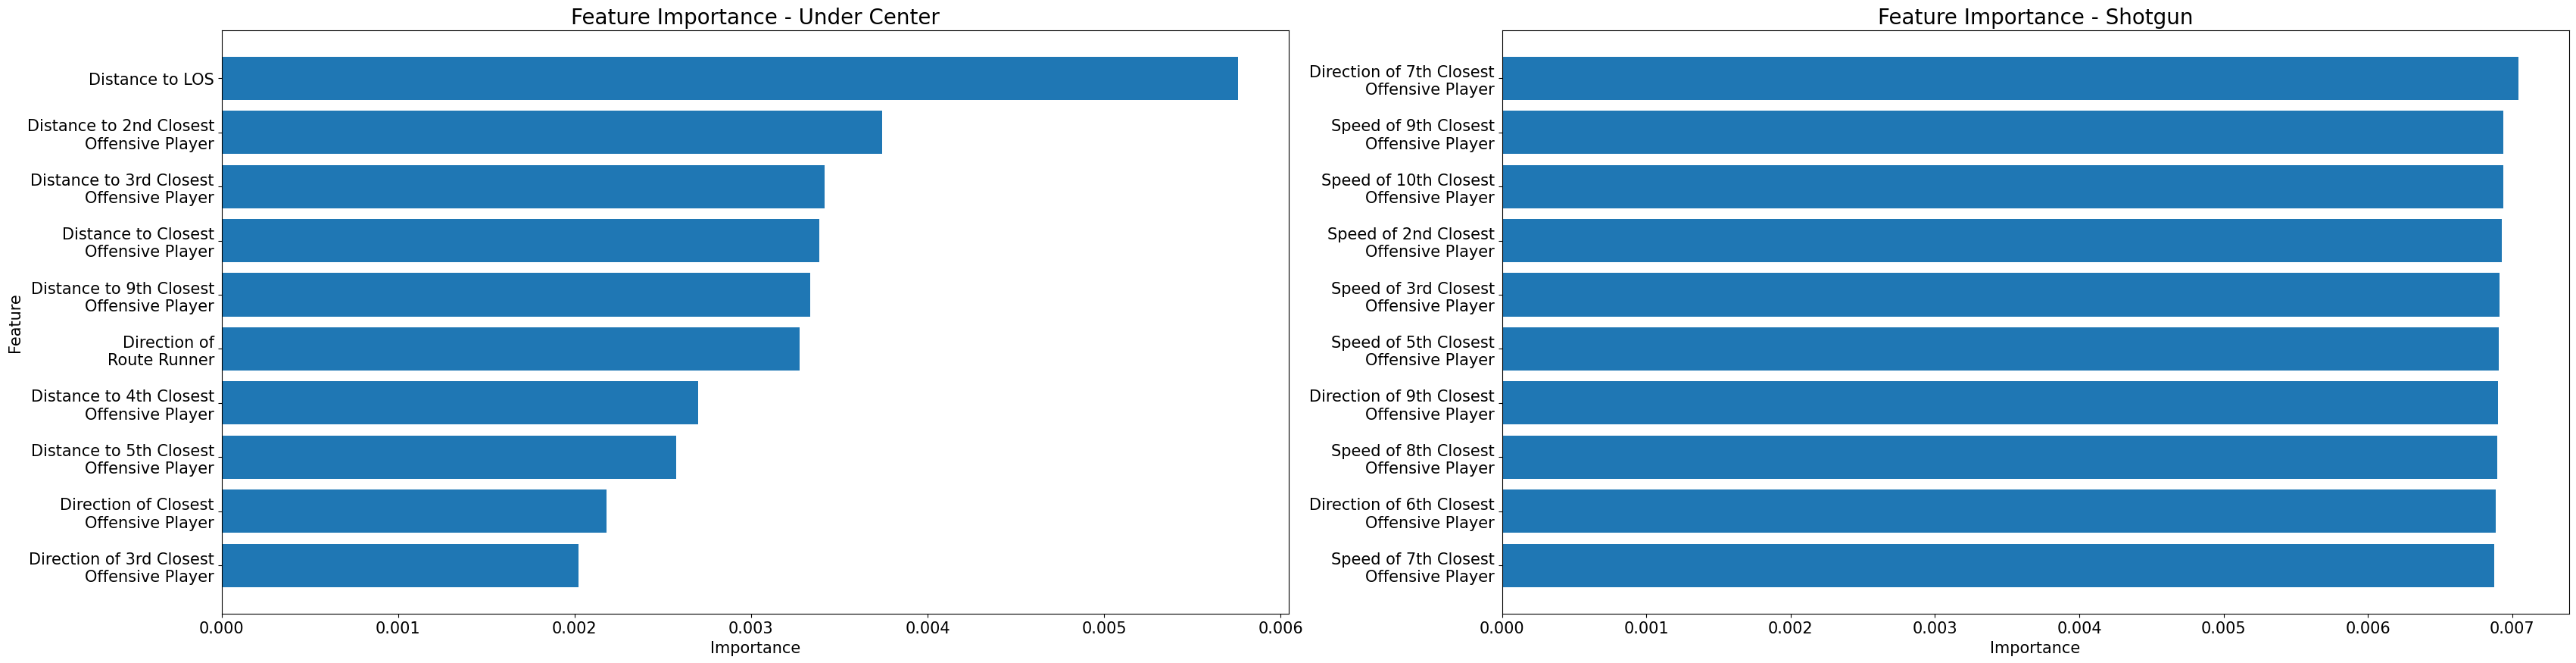

In [8]:
shotgunFeatureImportance = shotgunFeatureImportance.iloc[0:10]
# underCenterFeatureImportance

fig, ax = plt.subplots(1,2,figsize=(40,10),facecolor='#ffff')

# under center
ax[0].barh(underCenterFeatureImportance['Feature'],underCenterFeatureImportance['difference'])
# Show top values
ax[0].invert_yaxis()
ax[0].tick_params(axis='both', which='major', labelsize=15)
# Aesthetics
ax[0].set_title('Feature Importance - Under Center', fontsize=20)
ax[0].set_xlabel('Importance', fontsize=15)
ax[0].set_ylabel('Feature', fontsize=15)
ax[0].set_yticklabels(['Distance to LOS','Distance to 2nd Closest\nOffensive Player','Distance to 3rd Closest\nOffensive Player','Distance to Closest\nOffensive Player','Distance to 9th Closest\nOffensive Player','Direction of\nRoute Runner',
                       'Distance to 4th Closest\nOffensive Player','Distance to 5th Closest\nOffensive Player','Direction of Closest\nOffensive Player','Direction of 3rd Closest\nOffensive Player'])

# shotgun
ax[1].barh(shotgunFeatureImportance['Feature'],shotgunFeatureImportance['difference'])
# Show top values
ax[1].invert_yaxis()
ax[1].tick_params(axis='both', which='major', labelsize=15)
# Aesthetics
ax[1].set_title('Feature Importance - Shotgun', fontsize=20)
ax[1].set_xlabel('Importance', fontsize=15)
ax[1].set_yticklabels(['Direction of 7th Closest\nOffensive Player','Speed of 9th Closest\nOffensive Player','Speed of 10th Closest\nOffensive Player','Speed of 2nd Closest\nOffensive Player','Speed of 3rd Closest\nOffensive Player',
                       'Speed of 5th Closest\nOffensive Player','Direction of 9th Closest\nOffensive Player','Speed of 8th Closest\nOffensive Player','Direction of 6th Closest\nOffensive Player','Speed of 7th Closest\nOffensive Player'])

plt.savefig(
    './visuals/featureImportance.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)